In [25]:
# Cell 1: Imports, load processed data (reuse same path)
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

plt.style.use('seaborn-v0_8')
sns.set_context('talk')

DATA_PATH = '../data/raw/XAU_15m_data.csv'
DT_COL_CANDIDATES = ['datetime', 'time', 'timestamp', 'Date', 'date']
PRICE_COL_CANDIDATES = ['close', 'Close', 'PRICE', 'Price']

def detect_columns(df):
    dt_col = None
    for c in DT_COL_CANDIDATES:
        if c in df.columns: dt_col = c; break
    if dt_col is None: raise ValueError("No datetime column detected")

    price_col = None
    for c in PRICE_COL_CANDIDATES:
        if c in df.columns: price_col = c; break
    if price_col is None and 'close' in df.columns:
        price_col = 'close'
    if price_col is None: raise ValueError("No price column detected")
    return dt_col, price_col

raw = pd.read_csv(DATA_PATH,sep=";", low_memory=False)
dt_col, price_col = detect_columns(raw)
raw[dt_col] = pd.to_datetime(raw[dt_col], errors='coerce', utc=True)
df = raw.dropna(subset=[dt_col]).sort_values(dt_col).set_index(dt_col)

df.columns = [c.lower() for c in df.columns]
price_col = price_col.lower()
if price_col not in df.columns and 'close' in df.columns:
    price_col = 'close'

df = df.dropna()
df['ret'] = df[price_col].pct_change()
df['log_ret'] = np.log1p(df['ret'])
df = df.dropna(subset=['log_ret'])


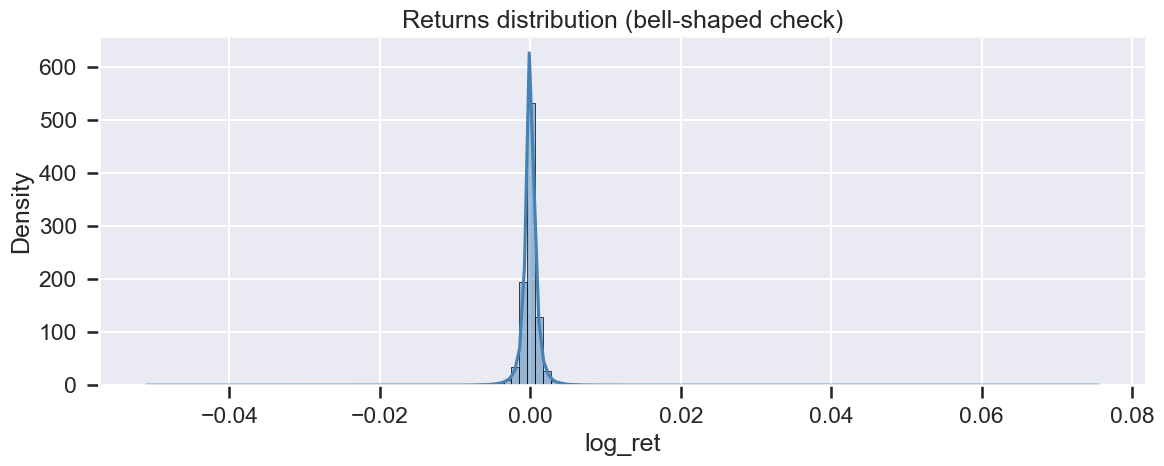

In [26]:
# Cell 2: Bell-shaped check (histogram with KDE)
plt.figure(figsize=(12, 5))
sns.histplot(df['log_ret'], bins=120, kde=True, stat='density', color='steelblue')
plt.title('Returns distribution (bell-shaped check)')
plt.tight_layout()
plt.show()


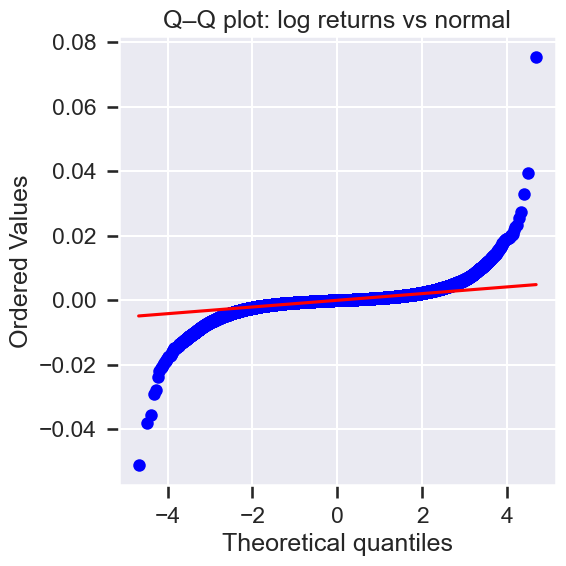

In [27]:
# Cell 3: Q–Q plot against Normal
plt.figure(figsize=(6, 6))
stats.probplot(df['log_ret'], dist="norm", plot=plt)
plt.title('Q–Q plot: log returns vs normal')
plt.tight_layout()
plt.show()


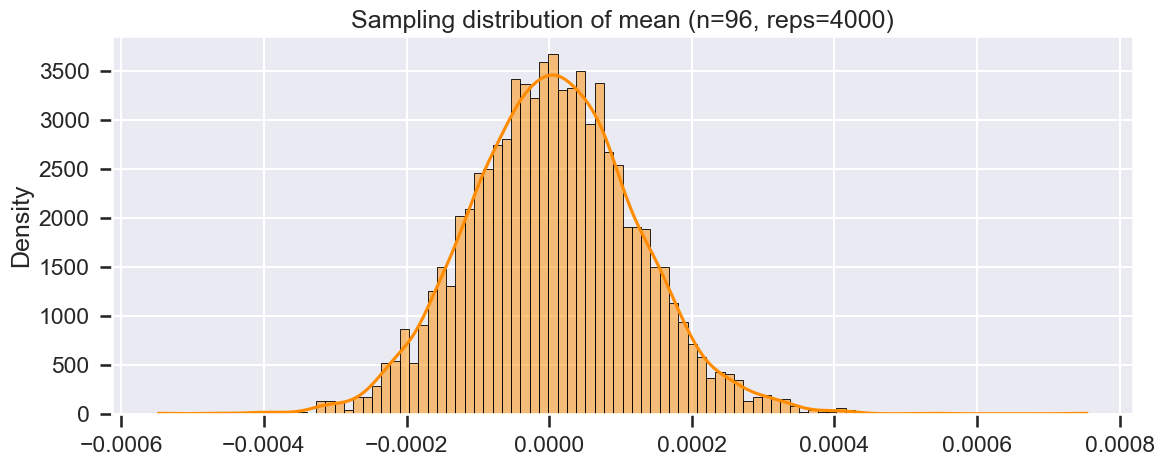

Sampling mean: 5.982991073682953e-06
Sampling std: 0.00011693458681123871


In [28]:
# Cell 4: Sampling distribution of the mean (n≈1 day)
WINDOW_1D = 96  # ~1 day for 15-min bars
REPS = 4000
rng = np.random.default_rng(42)
x = df['log_ret'].values
samples = []
for _ in range(REPS):
    idx = rng.integers(0, len(x), size=WINDOW_1D)
    samples.append(x[idx].mean())
samples = np.array(samples)

plt.figure(figsize=(12, 5))
sns.histplot(samples, bins=100, kde=True, stat='density', color='darkorange')
plt.title(f'Sampling distribution of mean (n={WINDOW_1D}, reps={REPS})')
plt.tight_layout()
plt.show()

print("Sampling mean:", samples.mean())
print("Sampling std:", samples.std())


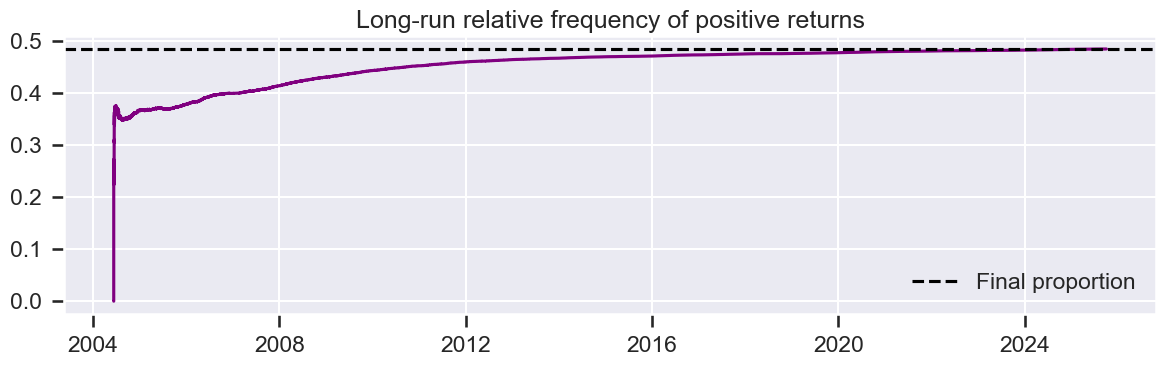

Final proportion of positive returns: 0.48505968512265235


In [29]:
# Cell 5: Long-run relative frequencies (sign of returns)
signs = np.sign(df['log_ret'].values)
# Map negative->0, zero->0, positive->1
signs_bin = (signs > 0).astype(int)
cum_pos = np.cumsum(signs_bin)
idx = np.arange(1, len(signs_bin)+1)
lr_freq = cum_pos / idx

plt.figure(figsize=(12, 4))
plt.plot(df.index[:len(lr_freq)], lr_freq, color='purple')
plt.axhline(lr_freq[-1], color='black', linestyle='--', label='Final proportion')
plt.legend()
plt.title('Long-run relative frequency of positive returns')
plt.tight_layout()
plt.show()

print("Final proportion of positive returns:", float(lr_freq[-1]))


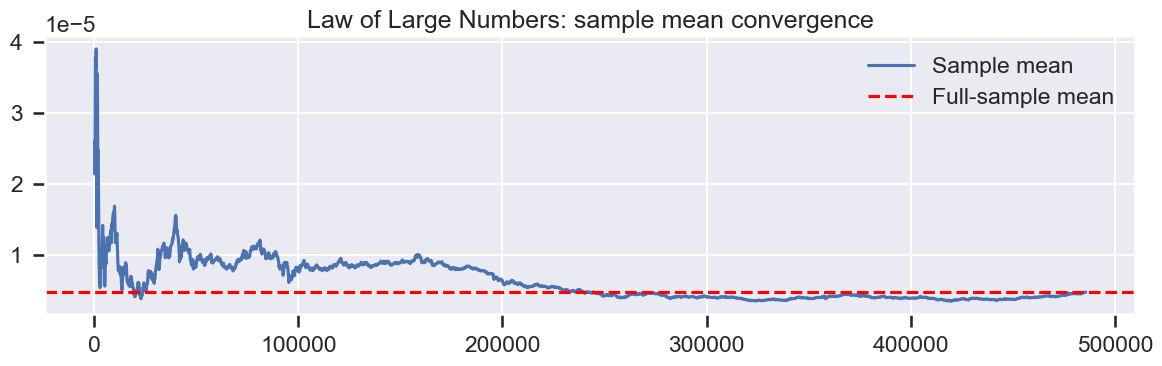

In [30]:
# Cell 6: Law of Large Numbers demonstration (sample mean convergence)
means = []
STEP = 200
x = df['log_ret'].values
for n in range(STEP, len(x), STEP):
    means.append(x[:n].mean())
n_axis = np.arange(STEP, STEP*len(means)+1, STEP)

plt.figure(figsize=(12, 4))
plt.plot(n_axis, means, label='Sample mean')
plt.axhline(x.mean(), color='red', linestyle='--', label='Full-sample mean')
plt.legend()
plt.title('Law of Large Numbers: sample mean convergence')
plt.tight_layout()
plt.show()


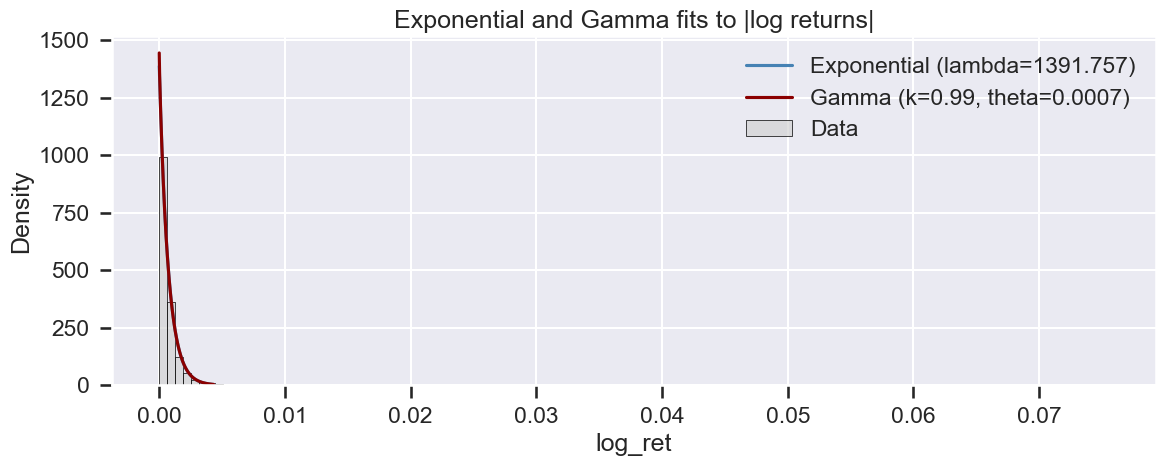

Exponential rate (lambda): 1391.757199
Gamma shape (k): 0.989865, scale (theta): 0.000726


In [31]:
# Cell 7: Exponential & Gamma visualization (on |returns|)
y = np.abs(df['log_ret']).clip(lower=0)
y = y[y > 0]  # strict positive

# Exponential MLE rate
lambda_hat = 1.0 / y.mean()

# Gamma fit (shape k, scale theta), fix loc=0
k_hat, loc_hat, theta_hat = stats.gamma.fit(y, floc=0)

xs = np.linspace(y.min(), np.quantile(y, 0.99), 400)

plt.figure(figsize=(12, 5))
sns.histplot(y, bins=120, stat='density', color='lightgray', alpha=0.7, label='Data')
plt.plot(xs, lambda_hat * np.exp(-lambda_hat * xs), color='steelblue', label=f'Exponential (lambda={lambda_hat:.3f})')
plt.plot(xs, stats.gamma.pdf(xs, k_hat, loc=0, scale=theta_hat), color='darkred', label=f'Gamma (k={k_hat:.2f}, theta={theta_hat:.4f})')
plt.legend()
plt.title('Exponential and Gamma fits to |log returns|')
plt.tight_layout()
plt.show()

print(f"Exponential rate (lambda): {lambda_hat:.6f}")
print(f"Gamma shape (k): {k_hat:.6f}, scale (theta): {theta_hat:.6f}")


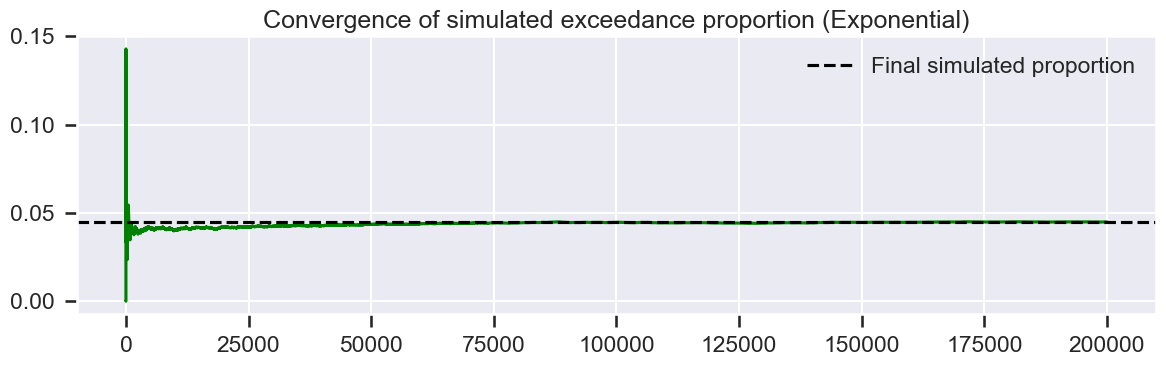

Final simulated proportion exceeding threshold=0.002247: 0.044870


In [32]:
# Cell 8: Simulated Exponential distribution and convergence of simulated proportion
# Simulate exponential with lambda_hat, estimate proportion exceeding a threshold and show convergence
rng = np.random.default_rng(123)
N_SIM = 200_000
exp_samples = rng.exponential(scale=1.0/lambda_hat, size=N_SIM)

threshold = np.quantile(y, 0.95)  # a high-magnitude threshold
exceed = (exp_samples > threshold).astype(int)
cum_prop = np.cumsum(exceed) / np.arange(1, N_SIM+1)

plt.figure(figsize=(12, 4))
plt.plot(cum_prop, color='green')
plt.axhline(cum_prop[-1], color='black', linestyle='--', label='Final simulated proportion')
plt.legend()
plt.title('Convergence of simulated exceedance proportion (Exponential)')
plt.tight_layout()
plt.show()

print(f"Final simulated proportion exceeding threshold={threshold:.6f}: {cum_prop[-1]:.6f}")


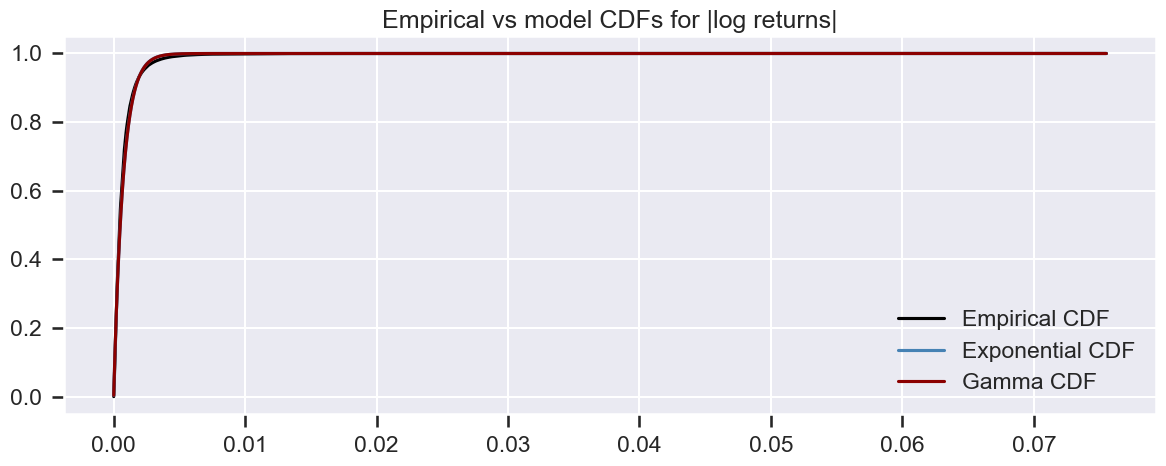

In [33]:
# Cell 9: CDF and PDF overlays for sanity check
# Empirical CDF of |log_ret| and model CDFs
y_sorted = np.sort(y.values)
emp_cdf = np.arange(1, len(y_sorted)+1) / len(y_sorted)

exp_cdf = 1.0 - np.exp(-lambda_hat * y_sorted)
gamma_cdf = stats.gamma.cdf(y_sorted, k_hat, loc=0, scale=theta_hat)

plt.figure(figsize=(12, 5))
plt.plot(y_sorted, emp_cdf, label='Empirical CDF', color='black')
plt.plot(y_sorted, exp_cdf, label='Exponential CDF', color='steelblue')
plt.plot(y_sorted, gamma_cdf, label='Gamma CDF', color='darkred')
plt.legend()
plt.title('Empirical vs model CDFs for |log returns|')
plt.tight_layout()
plt.show()


In [22]:
# Cell 10: Notes for ML/AI relevance (printed context)
print("""
Why these distribution checks matter:
- Returns often have heavy tails and skew; normality assumptions fail.
- Q–Q plots reveal deviations guiding robust modeling choices.
- Sampling distributions quantify uncertainty in means (risk of drift estimates).
- LLN builds confidence in stability with large samples.
- Exponential/Gamma fits for |returns| help stress-scenario simulation and risk tails.
- Convergence plots validate simulation reliability for downstream ML pipelines.
""")



Why these distribution checks matter:
- Returns often have heavy tails and skew; normality assumptions fail.
- Q–Q plots reveal deviations guiding robust modeling choices.
- Sampling distributions quantify uncertainty in means (risk of drift estimates).
- LLN builds confidence in stability with large samples.
- Exponential/Gamma fits for |returns| help stress-scenario simulation and risk tails.
- Convergence plots validate simulation reliability for downstream ML pipelines.

